# Machine Learning: K supercomputer double perovskite dataset

### Part 1: Data Processing
This notebook follows from a lecture given at Cal State LA from the weeks of May 20 to May 24, 2019.

Here is the plan: I have an Excel file containing the chemical formulae of double perovskite materials, as well as their bandgaps, calculated via an accurate method (HSE hybrid functional with spin-orbit coupling).

Each compound is a 'double perovskite', with a chemical composition of the form $A_2 BB' X_6$, where $A$ is either a polyatomic ion or an alkali metal, $B$ is some atom, and $X$ is a halogen.

I will use regular expressions to extract the specific atoms that make up the $A$, $B$, $B'$, and $X$ sites for each double perovskite, and generate atomic features. Then, I will use a machine learning algorithm to predict the band gap using atomic features.

Tha data set is downloaded from https://pubs.acs.org/doi/10.1021/acs.jpclett.7b02203

The first step is to import numpy (for numerical operations), pandas (for handling data frames), and pymatgen, which contains atomic data.

In [1]:
import pandas as pd
import numpy as np
from pymatgen.core.periodic_table import Element
%matplotlib inline

In [2]:
df = pd.read_excel('jz7b02203_si_002.xlsx')

Let's save it to a pkl file. This file will be a binary file, and considerably faster to load than the xlsx file, if you wish to re-run this notebook again.

In [3]:
df.to_pickle('df.pkl')

In [4]:
df.head()

,System,TotEne_PBE_Smear,TotEne_PBE_Nonsmear,TotEne_SOPBE,TotEne_SOHSE_Approx1,TotEne_SOHSE_Approx2,TotEne_SOHSE_Approx,DirectGap_PBE,DirectGap_SOPBE,DirectGap_SOHSE_Approx1,...,Ev_SOHSE_Approx1,Ev_SOHSE_Approx2,Ev_SOHSE_Approx,Ec_SOHSE_Approx1,Ec_SOHSE_Approx2,Ec_SOHSE_Approx,Mass_VBM,Mass_CBM,perovskite,nontoxicity
0,C4N4H24Be4I12,-207.385597,-207.384168,NaN,NaN,NaN,NaN,4.307587,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.2336,-0.7022,No,Yes
1,C4N4H24B4I12,-210.442946,-210.832772,-212.426721,-291.679667,-291.748642,-291.748642,1.957007,1.829610,3.180325,...,-6.328621,-6.344494,-6.344494,-3.180668,-3.164795,-3.164795,3.3445,-43.1810,No,Yes
2,C4N4H24C4I12,-207.448155,-207.445549,-209.150007,-292.435476,-292.514091,-292.514091,0.769122,0.695907,1.840094,...,-5.889648,-5.890998,-5.890998,-4.049554,-4.048204,-4.048204,2.1819,-0.5658,No,Yes
3,C4N4H24N4I12,-206.031947,-206.276663,-208.090457,-295.760101,-295.822950,-295.822950,1.067985,1.003489,2.382841,...,-6.217354,-6.219469,-6.219469,-3.899306,-3.897190,-3.897190,2.9718,-7.5010,No,Yes
4,C4N4H24Mg4I12,-203.355980,-203.353890,-204.897868,-281.359832,-281.435270,-281.435270,1.774819,1.606697,2.878062,...,-6.118930,-6.129990,-6.129990,-3.240868,-3.229808,-3.229808,1.3698,-0.3258,Yes,Yes


In [5]:
df.tail()

,System,TotEne_PBE_Smear,TotEne_PBE_Nonsmear,TotEne_SOPBE,TotEne_SOHSE_Approx1,TotEne_SOHSE_Approx2,TotEne_SOHSE_Approx,DirectGap_PBE,DirectGap_SOPBE,DirectGap_SOHSE_Approx1,...,Ev_SOHSE_Approx1,Ev_SOHSE_Approx2,Ev_SOHSE_Approx,Ec_SOHSE_Approx1,Ec_SOHSE_Approx2,Ec_SOHSE_Approx,Mass_VBM,Mass_CBM,perovskite,nontoxicity
11020,Cs4Hg2Pb2Cl12,-64.830507,-64.677965,-66.024060,-119.383818,-119.811363,-119.811363,2.128673,2.041891,3.317036,...,-6.493482,-6.604364,-6.604364,-4.078386,-3.967504,-3.967504,0.5089,-0.2990,Yes,No
11021,Cs4Hg2Tl2Cl12,-60.418179,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
11022,Cs4Tl2Bi2Cl12,-71.438912,-71.195789,-72.535615,-124.555184,-124.712130,-124.712130,1.912991,0.815462,2.005946,...,-6.155114,-6.158749,-6.158749,-4.149168,-4.145534,-4.145534,0.2150,-0.3949,Yes,No
11023,Cs4Tl2Pb2Cl12,-69.551930,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
11024,Cs4Pb2Bi2Cl12,-71.608804,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No


We can see both the compounds of the form $A_4 B_4 X_{12}$ and $A_4 B_2 B'_2 X_{12}$.

We only care about the chemical formulae (System) and the bandgap (LowGap_SOHSE_Approx). So, let's remove the unnecessary columns:

In [6]:
df = df[['System', 'LowGap_SOHSE_Approx']]

In [7]:
df.isnull().sum()

System                    0
LowGap_SOHSE_Approx    9102
dtype: int64

In [8]:
df.describe()

,LowGap_SOHSE_Approx
count,1923.000000
mean,2.914283
std,0.972486
min,-0.418709
25%,2.172608
50%,2.845078
75%,3.582940
max,5.730866


Looks like there are more than 80% NaN values and few negative values for bandgap. Lets remove these values because negative bandgap value doesnot make any physical sense.

In [9]:
df = df.dropna()

df = df[df['LowGap_SOHSE_Approx'] >= 0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA337B4E08>]],
      dtype=object)

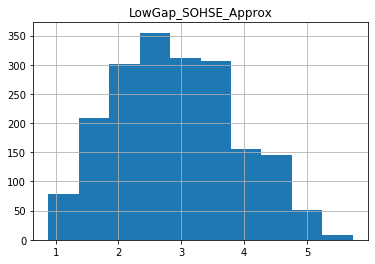

In [10]:
df.hist()

Now let's extract $A$, $B$, $B'$, and the $X$ sites of perovskites.

For the $A$ sites, there are three different types of ions: 
1. Methylammonium (C4N4H24)
2. Formamidinium (C4N8H20)
3. Caesium (Cs4)

We can use a regular expresssion to match for any of these three atoms: C4N4H24|C4N8H20|Cs4.

For convenience, we will rename the ions to abbreviated names (MA, FA, Cs). When the pandas.DataFrame.replace method takes in two strings, the first string is the string to replace, and the secon is the string that will be put in in place of the original string. inplace=True specifies that we wish to modify the object itself, rather than a copy.

In [11]:
a_sites = df['System'].str.extract(r'(C4N4H24|C4N8H20|Cs4)')

a_sites.replace('C4N4H24', 'MA', inplace = True)
a_sites.replace('C4N8H20', 'FA', inplace = True)
a_sites.replace('Cs4', 'Cs', inplace = True)

a_sites.head()

,0
1,MA
2,MA
3,MA
4,MA
5,MA


Now save this a_sites into column of df.

In [12]:
df['A_sites'] = a_sites

In [13]:
df.head()

,System,LowGap_SOHSE_Approx,A_sites
1,C4N4H24B4I12,3.179699,MA
2,C4N4H24C4I12,1.842794,MA
3,C4N4H24N4I12,2.322279,MA
4,C4N4H24Mg4I12,2.900182,MA
5,C4N4H24Al4I12,2.038116,MA


Similarly, we have to find the $B$ site.

The problem is that we need to differentiate the compounds written as $A_4B_2B'_2X_{12}$ (which we will call true_dbls) with the compounds written as $A_4B_4X_{12}$ (which we call false_dbls).

So let's plan to handle these two cases separately, and then join them into one data frame. 

What we need to do is see if there is a sequence of alphabetical characters, followed by a 2, followed by another sequence of alphabetical characters, followed by another 2. We can check for a group of alphabetical characters by using [a-zA-Z], and we can match for a sequence of characters by using +. We can use a lookahead (?=pattern) to check if pattern is ahead of this group of alphabetical characters. In this case, we'll check if there is a 2, followed by another [a-zA-Z]+ and then another 2.

We will use .copy() to avoid modifying the original data frame.

In [14]:
true_dbls = df[df['System'].str.contains(r'[a-zA-Z]+(?=2[a-zA-Z]+2)')].copy()
true_dbls.head()

,System,LowGap_SOHSE_Approx,A_sites
50,C4N4H24Be2Pb2I12,3.190090,MA
52,C4N4H24Be2Hg2I12,3.111010,MA
54,C4N4H24Be2Pt2I12,2.524556,MA
60,C4N4H24Be2Hf2I12,3.055102,MA
61,C4N4H24Be2Ba2I12,4.566838,MA


In [15]:
# match a group of alphabetical chars followed by a 2, another group of alphabetical chars,
# and then another 2
b_sites = true_dbls['System'].str.extract(r'([a-zA-Z]+)(?=2[a-zA-Z]+2)')
b_sites

# match a group of alphabetical chars
# followed by a 2, another group of alphabetical chars,
# and then a 12
b_prime_sites = true_dbls['System'].str.extract(r'([a-zA-Z]+)(?=2[a-zA-Z]+12)')
b_prime_sites

true_dbls['B_sites'] = b_sites
true_dbls['B_prime_sites'] = b_prime_sites

true_dbls.head()

,System,LowGap_SOHSE_Approx,A_sites,B_sites,B_prime_sites
50,C4N4H24Be2Pb2I12,3.190090,MA,Be,Pb
52,C4N4H24Be2Hg2I12,3.111010,MA,Be,Hg
54,C4N4H24Be2Pt2I12,2.524556,MA,Be,Pt
60,C4N4H24Be2Hf2I12,3.055102,MA,Be,Hf
61,C4N4H24Be2Ba2I12,4.566838,MA,Be,Ba


Since we know that here $B$ and $B'$ are the same. So, we can negate the condition for boolean indexing by using a ~. This will give us the false_dbls. 

In [16]:
false_dbls = df[~df['System'].str.contains(r'[a-zA-Z]+(?=2[a-zA-Z]+2)')].copy()

b_sites = false_dbls['System'].str.extract(r'([a-zA-Z]+)(?=4[a-zA-Z]+12)')

false_dbls['B_sites'] = b_sites
false_dbls['B_prime_sites'] = b_sites

false_dbls.head()

,System,LowGap_SOHSE_Approx,A_sites,B_sites,B_prime_sites
1,C4N4H24B4I12,3.179699,MA,B,B
2,C4N4H24C4I12,1.842794,MA,C,C
3,C4N4H24N4I12,2.322279,MA,N,N
4,C4N4H24Mg4I12,2.900182,MA,Mg,Mg
5,C4N4H24Al4I12,2.038116,MA,Al,Al


Concatenate true_dbls with false_dbls, and use regular expressions to find a group of characters followed by a 12 (i. e., $X$ site).

In [17]:
df_new = pd.concat([true_dbls, false_dbls], sort=False)

x_sites = df_new['System'].str.extract(r'([a-zA-Z]+)(?=12)')
df_new['X_sites'] = x_sites

df_new.head()

,System,LowGap_SOHSE_Approx,A_sites,B_sites,B_prime_sites,X_sites
50,C4N4H24Be2Pb2I12,3.190090,MA,Be,Pb,I
52,C4N4H24Be2Hg2I12,3.111010,MA,Be,Hg,I
54,C4N4H24Be2Pt2I12,2.524556,MA,Be,Pt,I
60,C4N4H24Be2Hf2I12,3.055102,MA,Be,Hf,I
61,C4N4H24Be2Ba2I12,4.566838,MA,Be,Ba,I


Let's create a dictionary of ionic radii using pymatgen. Element.from_Z creates an Element object from atomic number, from which we can extract properties such as the ionic radius.

For methylammonium and formamidinium, we will use results from a paper by Kieslich et al. (Chem. Sci. 2014, 5, 4712).

In [18]:
IONIC_R_DICT = {Element.from_Z(i).symbol:
                Element.from_Z(i).average_ionic_radius
                for i in range(1, 93)}

# Kieslich et al. Chem. Sci. 2014, 5, 4712
IONIC_R_DICT['MA'] = 2.17
IONIC_R_DICT['FA'] = 2.53

Create similar dictionaries for electronegativity, boiling point and melting point. Note that for electronegativity, pymatgen uses the capital letter X (this is because electronegativity is sometimes written using the Greek letter $\chi$ 'chi').

In [19]:
# Electronegativity -- 'Chi'
ENEG_DICT = {Element.from_Z(i).symbol:
             Element.from_Z(i).X for i in range(1, 93)}

#Boiling point
BOIL_DICT = {Element.from_Z(i).symbol:
             Element.from_Z(i).boiling_point
             if Element.from_Z(i).boiling_point
             else 0 for i in range(1, 93)}
#Melting point
MELT_DICT = {Element.from_Z(i).symbol:
             Element.from_Z(i).melting_point
             if type(Element.from_Z(i).melting_point) != str
             else 300. for i in range(1, 93)}

C:\Users\Amrit\Anaconda3\lib\site-packages\pymatgen\core\periodic_table.py:424: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
C:\Users\Amrit\Anaconda3\lib\site-packages\pymatgen\core\periodic_table.py:424: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
C:\Users\Amrit\Anaconda3\lib\site-packages\pymatgen\core\periodic_table.py:424: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


Read in a file for the Zunger valence radii $R_s$, $R_p$, and $R_d$, with which we can make a dictionary, of which we can generate a column of features.

In [20]:
zvr = pd.read_csv('zungervalenceradius.csv')

RS_DICT = {zvr.loc[i]['Element']:
           zvr.loc[i]['Rs'] for i in zvr.index}

RP_DICT = {zvr.loc[i]['Element']:
           zvr.loc[i]['Rp'] for i in zvr.index}

RD_DICT = {zvr.loc[i]['Element']:
           zvr.loc[i]['Rd'] for i in zvr.index}

Read in another file for the (first) ionization potentials, and make a dictionary out of this.

In [21]:
ip = pd.read_csv('ion.csv', sep=';',
                 header=None,
                 names=['Z', 'Element',
                        'IP1', 'IP2', 'IP3'])

IP_DICT = {ip.loc[i]['Element']:
           ip.loc[i]['IP1'] for i in ip.index}

Next, we wil make a function that add columns for each feature, modifying df inplace. It will take in the df we wish to modify, the feature dictionary, the column title, and the kind of site, and  add the desired column of features with the specified title, prefixed by the kind of site.

Note that for every $B$ site features, we use a symmetric representation. The choice of which is $B$ and which $B'$ is simply alphabetical and hence arbitrary, and we wish for the model to see the same features if $B$ and $B'$ are reversed.

Hence, for every $B$ site feature $f_B$ and $B'$ site feature $f_{B'}$, we return the sum $f_B + f_{B'}$ and the absolute difference $|f_B - f_{B'}|$.

In [22]:
def get_quant(df, feat_dict, title, kind):
    if kind == 'A':
        df['A_' + title] = df['A_sites'].replace(feat_dict)
    elif kind == 'B':
        summ = (df['B_sites'].replace(feat_dict) +
                df['B_prime_sites'].replace(feat_dict))
        dif = np.abs(df['B_sites'].replace(feat_dict) -
                     df['B_prime_sites'].replace(feat_dict))
        df['B_' + title + '_sum'] = summ
        df['B_' + title + '_dif'] = dif
    elif kind == 'X':
        df['X_' + title] = df['X_sites'].replace(feat_dict)

In [23]:
desired_features = [(IONIC_R_DICT, 'IonicRadius'),
                    (ENEG_DICT, 'Electronegativity'),
                    (BOIL_DICT, 'BoilingPoint'),
                    (MELT_DICT, 'MeltingPoint'),
                    (RS_DICT, 'Rs'),
                    (RP_DICT, 'Rp'),
                    (RD_DICT, 'Rd'),
                    (IP_DICT, 'FirstIonizationPotential')]

for feat_dict, title in desired_features:
    get_quant(df_new, feat_dict, title, 'B')
    get_quant(df_new, feat_dict, title, 'X')

In [24]:
# Generate the atomic radius for the A site

get_quant(df_new, IONIC_R_DICT, 'IonicRadius', 'A')

Finally, we will make one final feature, which is the tolerance factor. 

This gives some information as to what kind of crystal structure the perovskite will adopt. For a given perovskite with $A$, $B$, and $X$ sites, the tolerance factor $t$ is given by

$$ t = \frac{R_A + R_X}{\sqrt{2} \cdot (R_B + R_X)} $$
where $R_A$, $R_B$, and $R_X$ are the ionic radii of the $A$, $B$, and $X$, sites, respectively.

Since we have both $B$ and $B'$ sites, we calculate the tolerance factor for $B$ site ($t_B$) and the tolerance factor $B'$ site ($t_{B'}$). Again, we use the same trick from earlier to generate two symmetrized features; $t_B + t_{B'}$ and $|t_B - t_{B'}|$.

In [25]:
def get_tolerance_factor(df, title='ToleranceFactor'):
    Ra = df['A_sites'].replace(IONIC_R_DICT)
    Rb = df['B_sites'].replace(IONIC_R_DICT)
    Rbp =  df['B_prime_sites'].replace(IONIC_R_DICT)
    Rx = df['X_sites'].replace(IONIC_R_DICT)
    
    df[title + '_sum'] = (
        (Ra + Rx) / (np.sqrt(2) * (Rb + Rx)) +
        (Ra + Rx) / (np.sqrt(2) * (Rbp + Rx))
    )

    df[title + '_dif'] = np.abs(
        (Ra + Rx) / (np.sqrt(2) * (Rb + Rx)) -
        (Ra + Rx) / (np.sqrt(2) * (Rbp + Rx))
    )

In [26]:
get_tolerance_factor(df_new)

#Let's save this work into a pkl file

df_new.to_pickle('df_new.pkl')

In [27]:
df_new.head()

,System,LowGap_SOHSE_Approx,A_sites,B_sites,B_prime_sites,X_sites,B_IonicRadius_sum,B_IonicRadius_dif,X_IonicRadius,B_Electronegativity_sum,...,X_Rp,B_Rd_sum,B_Rd_dif,X_Rd,B_FirstIonizationPotential_sum,B_FirstIonizationPotential_dif,X_FirstIonizationPotential,A_IonicRadius,ToleranceFactor_sum,ToleranceFactor_dif
50,C4N4H24Be2Pb2I12,3.190090,MA,Be,Pb,I,1.7125,0.5325,1.27333,3.9,...,0.83,0.45,0.45,0.315,16.7393,1.9059,10.4513,2.17,2.32296,0.290427
52,C4N4H24Be2Hg2I12,3.111010,MA,Be,Hg,I,1.835,0.655,1.27333,3.57,...,0.83,0.475,0.475,0.315,19.7601,1.1149,10.4513,2.17,2.27352,0.339861
54,C4N4H24Be2Pt2I12,2.524556,MA,Be,Pt,I,1.395,0.215,1.27333,3.85,...,0.83,0.51,0.51,0.315,18.3226,0.3226,10.4513,2.17,2.47821,0.135175
60,C4N4H24Be2Hf2I12,3.055102,MA,Be,Hf,I,1.44,0.26,1.27333,2.87,...,0.83,0.63,0.63,0.315,16.1477,2.4975,10.4513,2.17,2.45338,0.160003
61,C4N4H24Be2Ba2I12,4.566838,MA,Be,Ba,I,2.08,0.9,1.27333,2.46,...,0.83,0.94,0.94,0.315,14.5343,4.1109,10.4513,2.17,2.1878,0.425582


# Part 2: Machine Learning

Let's try to see if we can predict the band gap using a machine learning algorithm (random forest).

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1921 entries, 50 to 9847
Data columns (total 33 columns):
System                            1921 non-null object
LowGap_SOHSE_Approx               1921 non-null float64
A_sites                           1921 non-null object
B_sites                           1921 non-null object
B_prime_sites                     1921 non-null object
X_sites                           1921 non-null object
B_IonicRadius_sum                 1921 non-null object
B_IonicRadius_dif                 1921 non-null object
X_IonicRadius                     1921 non-null object
B_Electronegativity_sum           1921 non-null object
B_Electronegativity_dif           1921 non-null object
X_Electronegativity               1921 non-null object
B_BoilingPoint_sum                1921 non-null object
B_BoilingPoint_dif                1921 non-null object
X_BoilingPoint                    1921 non-null object
B_MeltingPoint_sum                1921 non-null object
B_MeltingPo

t looks like the desired features are not floats, so we need to convert them.

In [30]:
for col in df_new.columns[6:]:
    df_new[col] = df_new[col].astype(np.float64)

In [31]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1921 entries, 50 to 9847
Data columns (total 33 columns):
System                            1921 non-null object
LowGap_SOHSE_Approx               1921 non-null float64
A_sites                           1921 non-null object
B_sites                           1921 non-null object
B_prime_sites                     1921 non-null object
X_sites                           1921 non-null object
B_IonicRadius_sum                 1921 non-null float64
B_IonicRadius_dif                 1921 non-null float64
X_IonicRadius                     1921 non-null float64
B_Electronegativity_sum           1921 non-null float64
B_Electronegativity_dif           1921 non-null float64
X_Electronegativity               1921 non-null float64
B_BoilingPoint_sum                1921 non-null float64
B_BoilingPoint_dif                1921 non-null float64
X_BoilingPoint                    1921 non-null float64
B_MeltingPoint_sum                1921 non-null float64
B

Let's use all the columns that contain numerical data (besides the band gap we which to predict), and use this as our $\boldsymbol{X}$, in which rows represent individual data observations, and columns represent features.

Let's set our $\boldsymbol{y}$ as a vector containing all of the band gaps. This is sometimes called a target vector. Then check the shapes of our $\boldsymbol{X}$ and $\boldsymbol{y}$:

In [32]:
X = df_new[df_new.columns[6:]]

y = df_new['LowGap_SOHSE_Approx']

X.shape, y.shape

((1921, 27), (1921,))

Now, let's use the function train_test_split to make splits for training and testing. We will use a test set size of $0.2$. The random_state=42 ensures that the same random split is returned every time (for the sake of reproducibility).

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1536, 27), (385, 27), (1536,), (385,))

### Random Forest 

In [35]:
rfr = RandomForestRegressor(random_state = 42, n_jobs = -1)

rfr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Let's train our model on training data

In [36]:
rfr.fit(X_train, y_train)

C:\Users\Amrit\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [37]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

print('Mean Squared Error:', metrics.mean_squared_error(y_test, rfr.predict(X_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rfr.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rfr.predict(X_test))))

Mean Squared Error: 0.28419785065471403
Mean Absolute Error: 0.3793655412987013
Root Mean Squared Error: 0.533102101529073


Next, we will try different values for hyperparameters that we took as default in the beginning.

In [38]:
from sklearn.model_selection import RandomizedSearchCV

Let's make the dictionary of hyperparameters:

In [39]:
hp_dict = {
    'n_estimators': [int(i) for i in np.linspace(50, 1000, 20)],
    'max_depth': [int(i) for i in np.linspace(10, 100, 10)] + [None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 'sqrt']    
}

hp_dict

{'n_estimators': [50,
  100,
  150,
  200,
  250,
  300,
  350,
  400,
  450,
  500,
  550,
  600,
  650,
  700,
  750,
  800,
  850,
  900,
  950,
  1000],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_split': [2, 5, 10, 15, 20],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 'sqrt']}

Let's make a RandomizedSearchCV object. We need to specify the algorithm (estimator). Let's set this to the random forest rfr we set earlier. The grid of configurations to try (param_distributions) will be the hp_dict dictionary we created. n_iter tests how many combinations we wish to try. Here it is 10 to run it quickly for demonstration purposes. cv dictates the $k$ value for $k$-fold cross validation. We use random_state=42 to ensure reproducibility. verbose=3 makes a lot of the information print, which is convenient in tracking the progress. Finally, n_jobs=-1 indicates that all cores will be used.

In [40]:
rand = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=hp_dict,
    n_iter=10,
    cv=3,
    random_state=42,
    verbose=3,
    n_jobs=-1
)

In [41]:
rand.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   44.6s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=-1,
                                                   oob_score=False,
                                                   random_state=42,...


In [42]:
rand.best_params_

{'n_estimators': 350,
 'min_samples_split': 5,
 'max_features': 0.5,
 'max_depth': 90}

In [43]:
rand.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [44]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, rand.best_estimator_.predict(X_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rand.best_estimator_.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rand.best_estimator_.predict(X_test))))

Mean Squared Error: 0.25410944822395176
Mean Absolute Error: 0.3637732862905896
Root Mean Squared Error: 0.5040926980466507


We can also see which columns (features) were most important for the random forest algorithm. This can help us whittle down the number of features in case they are too many features, and also help us interpret the model.

In [45]:
rand.best_estimator_.feature_importances_

array([0.02928105, 0.02071222, 0.0174927 , 0.20966352, 0.05428223,
       0.01836623, 0.04117425, 0.05902698, 0.01840578, 0.04581402,
       0.0371618 , 0.01642706, 0.03121912, 0.02422141, 0.0173211 ,
       0.03523402, 0.0466566 , 0.01823948, 0.02969565, 0.01776696,
       0.01971224, 0.06552189, 0.03108234, 0.02006746, 0.01059797,
       0.03402934, 0.03082659])

Finally, let's look at the names that these importances correspond to

In [46]:
sorted(list(zip(X.columns, rand.best_estimator_.feature_importances_)),
       key=lambda x: -x[1])

[('B_Electronegativity_sum', 0.2096635207097799),
 ('B_FirstIonizationPotential_sum', 0.06552189392073311),
 ('B_BoilingPoint_dif', 0.05902698287772896),
 ('B_Electronegativity_dif', 0.05428223256676176),
 ('B_Rp_dif', 0.046656597726735964),
 ('B_MeltingPoint_sum', 0.04581401504826194),
 ('B_BoilingPoint_sum', 0.04117425020310158),
 ('B_MeltingPoint_dif', 0.03716179672088477),
 ('B_Rp_sum', 0.035234024358767144),
 ('ToleranceFactor_sum', 0.034029336922216005),
 ('B_Rs_sum', 0.031219122180312232),
 ('B_FirstIonizationPotential_dif', 0.031082343246673656),
 ('ToleranceFactor_dif', 0.030826587092878256),
 ('B_Rd_sum', 0.02969565455536849),
 ('B_IonicRadius_sum', 0.029281045877120136),
 ('B_Rs_dif', 0.02422141260885283),
 ('B_IonicRadius_dif', 0.020712218265346707),
 ('X_FirstIonizationPotential', 0.02006745688793516),
 ('X_Rd', 0.019712241592521832),
 ('X_BoilingPoint', 0.018405775291338862),
 ('X_Electronegativity', 0.018366227753744024),
 ('X_Rp', 0.018239480687084697),
 ('B_Rd_dif', 0.

# XGBoost

In [49]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb

In [50]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

C:\Users\Amrit\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [51]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.4, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

In [52]:
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

[13:53:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
import warnings
warnings.filterwarnings("ignore")
rmse = np.sqrt(mean_squared_error(y_test, preds))
scores = cross_val_score(xg_reg, X_train, y_train, cv =10)

print('Mean Squared Error:', metrics.mean_squared_error(y_test, preds))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, preds)))
print("Mean cross-validation score: %.4f" % scores.mean())

[13:53:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:17] WARNI

In [54]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=10,
                    num_boost_round=10000,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)

[13:53:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:29] WARNI

In [55]:
cv_results.tail(10)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
168,0.422209,0.006435,0.557093,0.051659
169,0.422174,0.006446,0.557119,0.051637
170,0.421974,0.006463,0.557052,0.051686
171,0.421928,0.006508,0.557061,0.051680
172,0.421882,0.006531,0.557062,0.051679
173,0.421768,0.006610,0.557011,0.051725
174,0.421768,0.006610,0.557011,0.051725
175,0.421768,0.006610,0.557011,0.051725
176,0.421702,0.006666,0.556979,0.051743
177,0.421637,0.006685,0.556933,0.051763


In [56]:
print('Root Mean Squared Error:', cv_results['test-rmse-mean'].min())

Root Mean Squared Error: 0.5569331


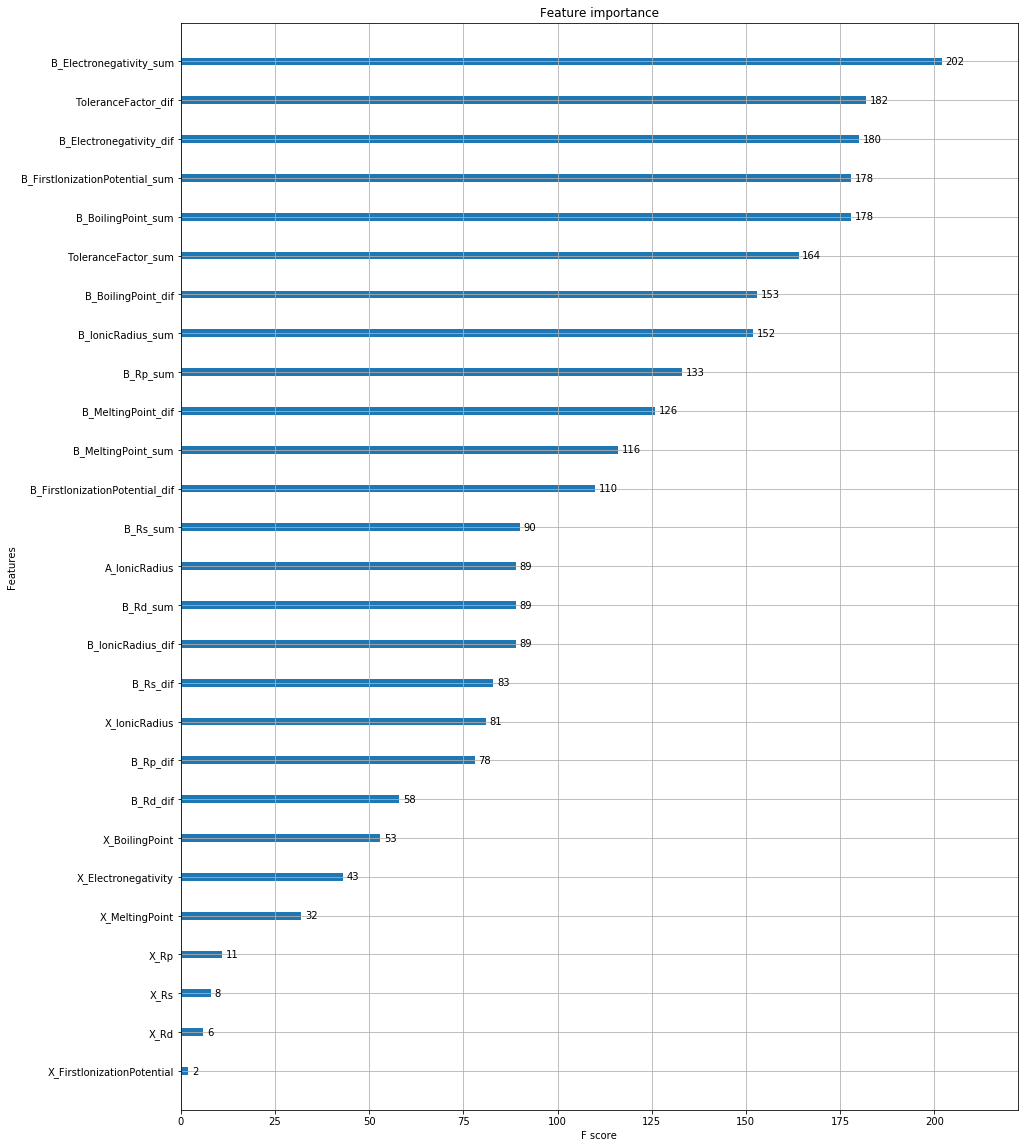

In [60]:
import matplotlib.pyplot as plt
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()